# Step #1 Load the Titanic Data

In [5]:
# A tutorial for this file is available at www.relataly.com

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# set file path
filepath = "data/titanic/"

# Load train and test datasets
train_df = pd.read_csv(filepath + 'titanic-train.csv')
test_df = pd.read_csv(filepath + 'titanic-test.csv')
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

# Step #2 Preprocess and Explore the Data

In [28]:
# Define a function for preprocessing the train and test data 
def preprocess(df):
    
    # Delete some columns that we will not use
    new_df = df[df.columns[~df.columns.isin(['Cabin', 'PassengerId', 'Name', 'Ticket'])]].copy()
    
    # Replace missing values
    for i in new_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns:
        new_df[i].fillna(new_df[i].mean(), inplace=True)
    new_df['Embarked'].fillna('C', inplace=True)
    
    # Decode categorical values as integer values
    new_df_b = new_df.copy()
    new_df_b['Sex'] = np.where(new_df_b['Sex']=='male', 0, 1) 
    
    cleanups = {"Sex":     {"m": 0, "f": 1},
                "Embarked": {"S": 1, "Q": 2, "C": 3}}
    new_df_b.replace(cleanups, inplace=True)
    x = new_df_b.drop(columns=['Survived'])
    y = new_df_b['Survived']  
    
    return x, y

# Create the training dataset train_df and the label dataset
x_df, y_df = preprocess(train_df)
x_df.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    0  22.0      1      0   7.2500         1
1       1    1  38.0      1      0  71.2833         3
2       3    1  26.0      0      0   7.9250         1
3       1    1  35.0      1      0  53.1000         1
4       3    0  35.0      0      0   8.0500         1

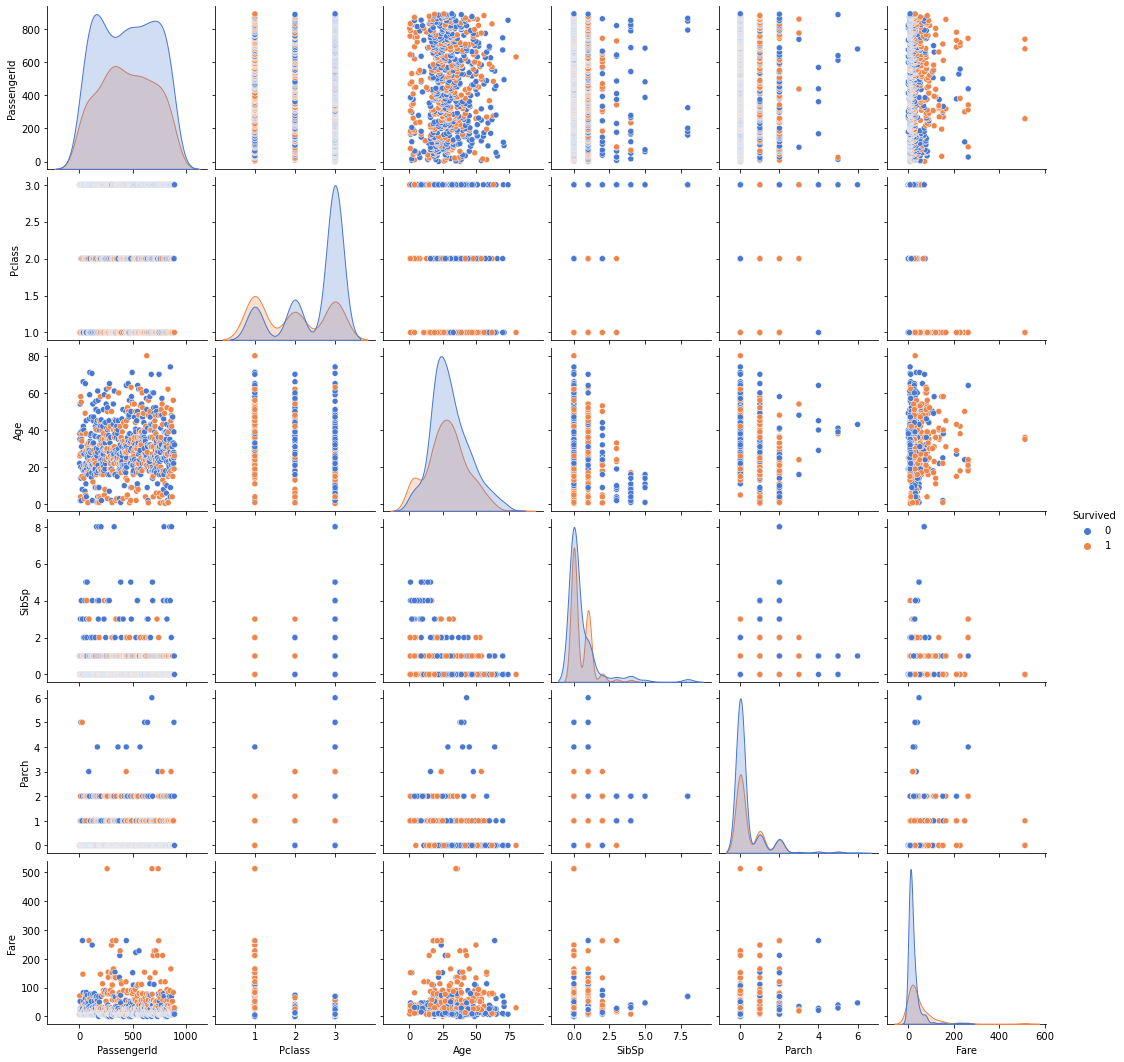

In [3]:
# # Create histograms for feature columns separated by prediction label value
df_plot = train_df.copy()

# class_columnname = 'Churn'
sns.pairplot(df_plot, hue="Survived", height=2.5, palette='muted')

# Step #3 Split the Data into Train and Test

In [4]:
# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)

# Step #4 Train a single Random Forest Classification Model

([<matplotlib.axis.YTick at 0x26a71ea5be0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

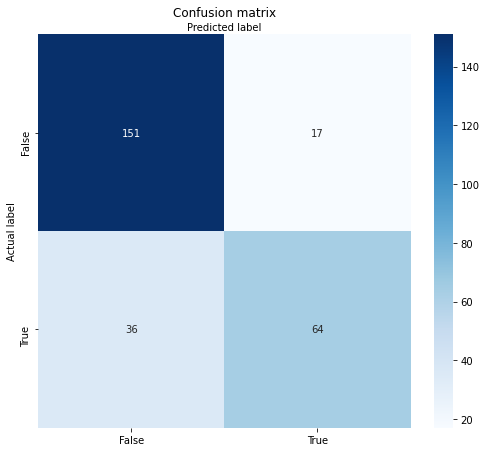

In [5]:
# Train a single random forest classifier - parameters are a best guess
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators = 100)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.xlabel('Predicted label') 
plt.ylabel('Actual label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

# Step #5 Hyper-parameter-tuning Using Grid Search

In [6]:
# Define parameters
max_depth=[2, 8, 16]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the gridsearch
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.79611613 0.78005161 0.79290323 0.81387097 0.82187097 0.81867097
 0.78818065 0.78816774 0.78498065], using {'max_depth': 8, 'n_estimators': 128}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.057045      0.001108         0.005001        0.000001   
1       0.112051      0.002088         0.009490        0.000775   
2       0.221600      0.003740         0.016487        0.000448   
3       0.061998      0.001410         0.005801        0.000400   
4       0.122886      0.002652         0.009587        0.000480   
5       0.250295      0.007654         0.018557        0.000836   
6       0.065602      0.000505         0.005800        0.000399   
7       0.127662      0.003297         0.008600        0.004080   
8       0.259617      0.003121         0.018873        0.000537   

  param_max_depth param_n_estimators                                  params  \
0               2                 64    {'max_depth': 2, 'n_estimators': 64}   
1               2                128   {'max_depth': 2, 'n_estimators': 128}   
2               2                256   {'max_depth': 2, 'n_estimators': 256}   
3               8                 64    {'max_depth': 8, 'n_estimators': 64}   
4               8                128   {'max_depth': 8, 'n_estimators': 128}   
5               8                256   {'max_depth': 8, 'n_estimators': 256}   
6              16                 64   {'max_depth': 16, 'n_estimators': 64}   
7              16                128  {'max_depth': 16, 'n_estimators': 128}   
8              16                256  {'max_depth': 16, 'n_estimators': 256}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0              0.824              0.800              0.784           0.774194   
1              0.760              0.824              0.784           0.750000   
2              0.792              0.824              0.784           0.774194   
3              0.784              0.824              0.792           0.806452   
4              0.784              0.848              0.808           0.806452   
5              0.800              0.824              0.800           0.806452   
6              0.736              0.808              0.784           0.766129   
7              0.752              0.800              0.784           0.758065   
8              0.752              0.784              0.776           0.766129   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.798387         0.796116        0.016883                4  
1           0.782258         0.780052        0.025523                9  
2           0.790323         0.792903        0.016756                5  
3           0.862903         0.813871        0.028044                3  
4           0.862903         0.821871        0.029089                1  
5           0.862903         0.818671        0.023797                2  
6           0.846774         0.788181        0.037557                6  
7           0.846774         0.788168        0.034078                7  
8           0.846774         0.784981        0.032690                8

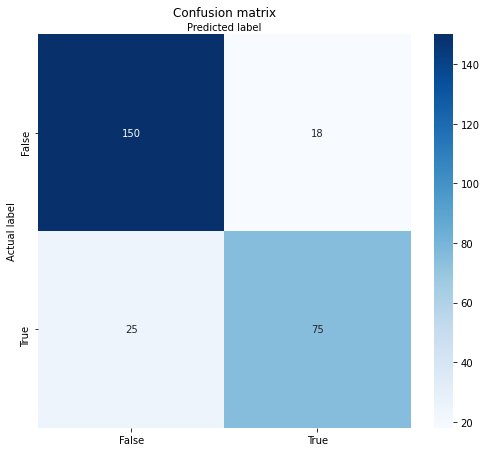

In [7]:
# Extract the best decision forest 
best_clf = grid_results.best_estimator_
y_pred = best_clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)
tick_marks = [0.5, 1.5]